In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stock_analysis import StockVisualizer, StockReader
from stock_analysis.utils import group_stocks, make_portfolio

In [2]:
start_date = '2014-01-01'
end_date = '2024-01-01'
reader = StockReader(start_date, end_date)

In [3]:
# get FAANG data
fb, aapl, amzn, nflx, goog = (
    reader.get_ticker_data(ticker)
    for ticker in ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG']
)

In [5]:
# group FAANG data
faang = group_stocks(
    {
        'Facebook': fb,
        'Apple': aapl,
        'Amazon': amzn,
        'Netflix': nflx,
        'Google': goog
    }
)

# create faang portfolio, clean data
faang_portfolio = make_portfolio(faang)
del faang_portfolio['high']
del faang_portfolio['low']
del faang_portfolio['open']
del faang_portfolio['name']

# calculate and add daily returns
faang_portfolio['daily_return']= faang_portfolio['close'].pct_change()
faang_portfolio.to_csv('portfolio_data/faang_portfolio.csv')
faang_portfolio = faang_portfolio.dropna()
faang_portfolio.tail()

,adj_close,close,volume,daily_return
date,,,,
2023-12-22,1329.643311,1329.890030,99562900,-0.004588
2023-12-26,1335.053986,1335.300003,77089700,0.004068
2023-12-27,1337.303833,1337.549988,112580000,0.001685
2023-12-28,1336.823318,1337.070023,86808700,-0.000359
2023-12-29,1325.994629,1326.239990,115010500,-0.008100


In [6]:
# get Fama French Five Factor Model Data
famafrench = pd.read_csv('famafrench_data/F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=3, index_col=0)
famafrench['date'] = pd.to_datetime(famafrench.index, format='%Y%m%d')
famafrench.set_index('date', inplace=True)
famafrench.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
2023-12-22,0.21,0.61,0.09,-0.64,0.19,0.021
2023-12-26,0.48,0.81,0.46,-0.34,-0.15,0.021
2023-12-27,0.16,0.16,0.12,-0.31,-0.14,0.021
2023-12-28,-0.01,-0.38,0.03,-0.32,0.15,0.021
2023-12-29,-0.43,-1.13,-0.37,0.67,-0.07,0.021


In [8]:
# merge the dataframes based on the date index
merged_data = famafrench.join(faang_portfolio['daily_return'], how='inner')
merged_data.to_csv('portfolio_data/merged_data.csv')
merged_data.head()

## note: python automatically fits time frame data

,Mkt-RF,SMB,HML,RMW,CMA,RF,daily_return
date,,,,,,,
2014-01-03,0.03,0.40,0.04,-0.36,0.14,0.0,-0.004730
2014-01-06,-0.34,-0.54,0.29,-0.32,0.10,0.0,0.013908
2014-01-07,0.68,0.31,-0.37,-0.07,-0.27,0.0,-0.008715
2014-01-08,0.04,-0.01,-0.11,-0.48,-0.02,0.0,0.005165
2014-01-09,0.02,0.17,-0.44,-0.54,-0.42,0.0,-0.012237


In [1]:
# calulate residual returns
merged_data['residual_return'] = merged_data.daily_return - merged_data.RF
merged_data.tail()

NameError: name 'merged_data' is not defined

In [10]:
# prepare data for regression
y = merged_data['residual_return']
X = merged_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]

X_sm = sm.add_constant(X)

# fit regression date
model = sm.OLS(y, X_sm).fit()

# print regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        residual_return   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     687.6
Date:                Tue, 13 Feb 2024   Prob (F-statistic):               0.00
Time:                        21:05:32   Log-Likelihood:                 7401.3
No. Observations:                2515   AIC:                        -1.479e+04
Df Residuals:                    2509   BIC:                        -1.476e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0041      0.000    -16.258      0.0

## What does this regression tell us? 
Alpha = -0.0041

## Data Visualization

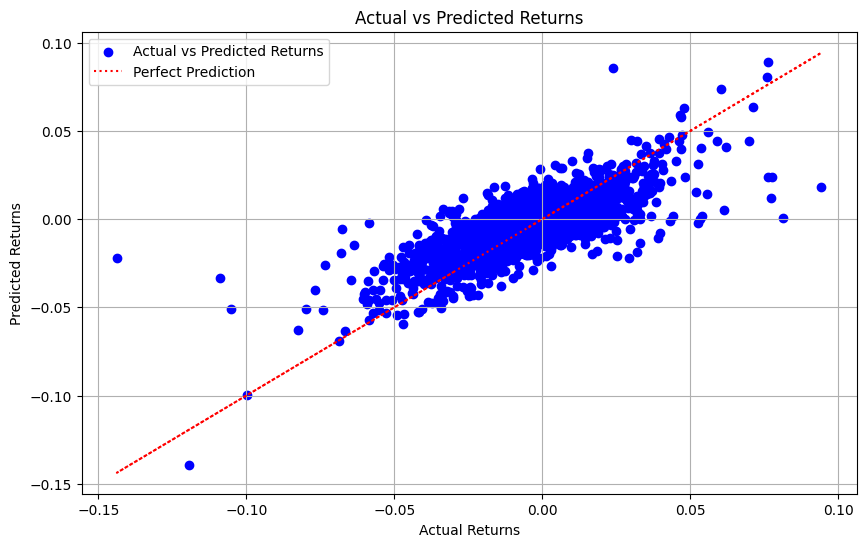

In [13]:
# plot actual vs predicted returns
plt.figure(figsize=(10, 6))
plt.scatter(y, model.predict(X_sm), color='blue', label='Actual vs Predicted Returns')
plt.plot(y, y, color='red', linestyle=':', label='Perfect Prediction')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
faang_visualizer = StockVisualizer(faang)

fx = faang_visualizer.evolution_over_time(
    'adj_close',
    figsize = (15, 8),
    legend = True,
    title = 'FAANG Portfolio From 2014-2024'
)

faang_visualizer.add_reference_line( 
    fx,
    x = faang_portfolio.high.idxmax(),
    color = 'red',
    linestyle = ':',
    label=f'highest value ({faang.high.idxmax():%b %d %y})',
    alpha = 0.5
)

fx.set_ylabel('adjusted close (USD)')
plt.show()